In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from ipywidgets import interact, widgets,fixed, interact_manual

import warnings
warnings.filterwarnings("ignore")

In [23]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# t-distributed stochastic neighbor embedding

*Dr.-Ing. Christian Herff*



<img style="float: right;" width=30% src="qr.png">
<br><br><br>
https://bitly.cx/tvs3


christian.herff@gmail.com

### Warum?

* Hochdimensionale Samples schwierig zu visualisieren!
* Nicht-lineare Dimensionsreduktion


<img  width=30% src="tsne_cells.png">




<small>
Yao, Z., van Velthoven, C. T., Kunst, M., Zhang, M., McMillen, D., Lee, C., ... & Zeng, H. (2023). A high-resolution transcriptomic and spatial atlas of cell types in the whole mouse brain. Nature, 624(7991), 317-332.

### Grundidee

* Bette Datenpunkte in niedrigdimensionalen Raum ein (**Embedding**)
* Nachbarschaften bewahren (**Neighbor**)
* Nachbarschaften als gemeinsame Wahrscheinlichkeitsverteilungen darstellen (**Stochastic**)
* Für niedrige Dimensionalität wähle *t-Verteilung* (**t-distributed**)
* Vergleiche Verteilungen (Kullback-Leibler Divergenz)
* Punkte mit Gradientenabstieg verschieben

<br><br><br>

<small>
Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(11)

Hinton, G. E., & Roweis, S. (2002). Stochastic neighbor embedding. Advances in neural information processing systems, 15.
</small>

<img style="float: right;" width=20% src="original_embedding.png">

### Embedding
* Es wird **keine** Projektion gelernt.
* Erstelle Punkte zufällig im niedrigdimensionalen Raum aus ${\mathcal {N}}(0,10 ^{-4})$.

### Neighbor
* **Idee:** Punkte die im ursprünglichen Merkmalsraum nah beieinander sind, sollen auch im Zielraum nah beieinander sein.
* Im ursprünglichen Merkmalsraum werden die Distanzen der Punkte zueinander berechnet.
* Keine zusätzlichen Informationen als diese Distanzmatrix!
* Übliche Probleme von Euklidische Distanz:
    * Skalierung
    * Fluch der Dimensionalität

<img style="float: left;" width=50% src="points_w_distances.png">

### Stochastic
* Bestimme gemeinsame Wahrscheinlichkeitsverteilungs $p_{ij}$ aus der Distanzmatrix.
* **Interpretation:** Wahrscheinlichkeit, dass Punkt $i$ Punkt $j$ als seinen Nachbarn wählen würde.
* Dafür zuerst die bedingten Warscheinlichkeiten errechnen:
$${\displaystyle p_{j\mid i}={\frac {\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{j}\rVert ^{2}/2\sigma _{i}^{2})}{\sum _{k\neq i}\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{k}\rVert ^{2}/2\sigma _{i}^{2})}}}$$
* Und diese dann in die gemeinsame Wahrscheinlichkeitsverteilung umformen:
$${\displaystyle p_{ij}={\frac {p_{j\mid i}+p_{i\mid j}}{2N}}}$$

### t-distributed
<img style="float: right;" width=30% src="tVsNormal.png">

* Für den Zielraum wähle die student $t$-Verteilung:
$${\displaystyle q_{ij}={\frac {(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}}{\sum _{k}\sum _{l\neq k}(1+\lVert \mathbf {y} _{k}-\mathbf {y} _{l}\rVert ^{2})^{-1}}}}$$
* Löst **Crowding problem**.

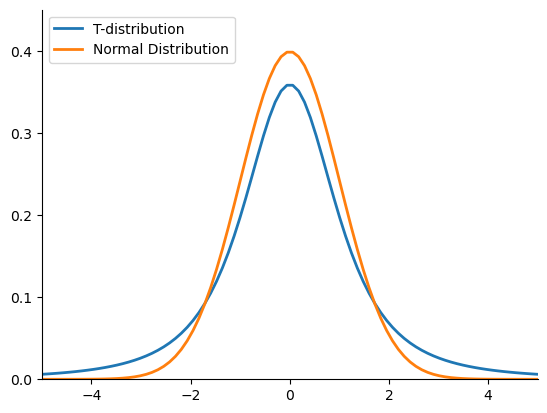

In [3]:
from scipy.stats import t,norm
df = 2.3
fig, ax =plt.subplots()
x = np.linspace(t.ppf(0.01, df),
                t.ppf(0.99, df), 100)
rv = t(df)
#ax.plot(x, t.pdf(x, df),
#       'r-', lw=5, alpha=0.6, label='t pdf')
ax.plot(x,rv.pdf(x),linewidth=2,label='T-distribution')
ax.plot(x,norm.pdf(x,0,1),linewidth=2,label='Normal Distribution')
plt.legend(loc="upper left")
ax.set_xlim([-5, 5])
ax.set_ylim([0,0.45])
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [4]:
def get_low_dim_affinities(Y):
    q_ij = np.zeros(shape=(Y.shape[0], Y.shape[0]))
    for i in range(0, Y.shape[0]):
        norm = np.linalg.norm(Y[i] - Y, axis=1)
        q_ij[i, :] = (1 + norm**2) ** (-1)
    # Set p = 0 if j = i
    np.fill_diagonal(q_ij, 0)
    q_ij = q_ij / q_ij.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0) for numerical stability
    epsilon = np.nextafter(0, 1)
    q_ij = np.maximum(q_ij, epsilon)
    return q_ij

In [5]:
def grid_search(diff_i, i, perplexity):
    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for sig_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * sig_search**2))
        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (epsilon -> 0)
        epsilon = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), epsilon)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            sig = sig_search

    return sig

In [6]:
def get_affinities(X,perplexity=10):
    p_ij = np.zeros(shape=(X.shape[0], X.shape[0]))
    for i in range(0, X.shape[0]):
        sig_i = grid_search(X[i] - X, i, perplexity)  # Grid Search for σ_i
        norm = np.linalg.norm(X[i] - X, axis=1)
        p_ij[i, :] = np.exp(-(norm**2) / (2 * sig_i**2))
        # Set p = 0 if j = i
        np.fill_diagonal(p_ij, 0)
        p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])


    
    epsilon = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, epsilon)
    p_ij_symmetric = np.zeros(shape=p_ij.shape)
    for i in range(0, X.shape[0]):
        for j in range(0, X.shape[0]):
            p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * X.shape[0])

    # Set 0 values to minimum numpy value (ε approx. = 0) for numerical stability
    p_ij_symmetric = np.maximum(p_ij_symmetric, epsilon)
    return p_ij_symmetric

In [7]:
def get_gradient(p_ij, q_ij, Y):
    gradient = np.zeros(shape=(Y.shape[0], Y.shape[1]))
    for i in range(0, Y.shape[0]):
        A = np.array([(p_ij[i, :] - q_ij[i, :])])
        B = np.array([(1 + np.linalg.norm(Y[i] - Y, axis=1)) ** (-1)])
        gradient[i] = 4 * np.sum((A * B).T * (Y[i] - Y), axis=0)
    return gradient

### Vergleiche Verteilungen & Gradientenabstieg
* Kullback-Leibler Divergenz zwischen ursprünglicher und niedrigdimensionaler Wahrscheinlichkeitsverteilung:
$${\displaystyle \mathrm {KL} \left(P\parallel Q\right)=\sum _{i\neq j}p_{ij}\log {\frac {p_{ij}}{q_{ij}}}}$$
* Gibt uns Gradienten:
$$ {\displaystyle {\frac {\delta C}{\delta y_{i}}}=4\sum _{j}(p_{ij}-q_{ij})(1+\lVert y_{i}-y_{j}\rVert ^{2})^{-1}(y_{i}-y_{j})} $$

### Full update with momentum
$${\displaystyle Y^{(t)}=Y^{(t-1)}-\eta {\frac {\delta C}{\delta Y}}+\alpha (t)\left(Y^{(t-1)}-Y^{(t-2)}\right)}$$

<img style="float: center;" width=80% src="pseudocode_tsne.png">

### <u>simplified t-SNE</u>
**Input:** Data $X$,  Target dimensionality $n$, Number of iterations $T$, learning rate $\eta$

**Output:** low-dimensional data representation $Y^{(T)} = \{y_1, y_2, \ldots, y_n\}$

* Initialize random map $Y^{(0)}$ from ${\mathcal {N}}(0,10 ^{-4})$

* Compute pairwise affinities $p_{j|i}$ of $X$

* For $t=0$ to $T$ iterations:
    1. compute low-dimensional affinities $q_{i|j}$
    2. Compute gradient $\frac {\delta C}{\delta y_{i}}$
    3. Update $Y^{(t)}=Y^{(t-1)}-\eta \frac {\delta C}{\delta y_{i}}$

In [8]:
def simpleTSNE(X,n_dim=2,T=50,eta=200):
    y = np.zeros((t,x.shape[0],n_dim))
    y[0,:,:] = np.random.normal(loc=0, scale=1e-4, size=(X.shape[0], n_dim))
    p_ij = get_affinities(X)
    for t in range(1,T):
        q_ij = get_low_dim_affinities(y[t-1,:,:])
        gradient = get_gradient(p_ij,q_ij,y[t-1,:,:])
        y[t,:,:] = y[t-1,:,:] - eta * gradient
    return y[t,:,:]

In [9]:
def simpleTSNEwithSaving(X,n_dim=2,T=50,eta=200):
    all_q=np.zeros((T,X.shape[0],X.shape[0]))
    all_gradients=np.zeros((T,X.shape[0],n_dim))
    costs=np.zeros(T-1)
    y = np.zeros((T,X.shape[0],n_dim))
    y[0,:,:] = np.random.normal(loc=0, scale=1e-4, size=(X.shape[0], n_dim))
    p_ij = get_affinities(X)
    for t in range(1,T):
        
        q_ij = get_low_dim_affinities(y[t-1,:,:])
        all_q[t-1,:,:]=q_ij
        
        cost = np.sum(p_ij * np.log(p_ij / q_ij))
        costs[t-1]=cost
        
        gradient = get_gradient(p_ij,q_ij,y[t-1,:,:])
        all_gradients[t-1,:,:]=gradient
        y[t,:,:] =  y[t-1,:,:] - eta * gradient
    return y, costs, all_gradients, p_ij, all_q

In [10]:
def plotHighLow(iteration,point,showGradient=False):
    eta=5
    fig,ax=plt.subplots(2,2,figsize=(7.5,6))
    ax[0,0].set_title('Original')
    ax[0,0].scatter(a[:,0],a[:,1],c=[1,2,3,4],s=400)
    for i in range(a.shape[0]):
        ax[0,0].scatter(a[i,0],a[i,1], marker="$"+str(i)+"$")
    ax[0,0].set_xlim(-0.1,np.max(a[:,0]+0.1))
    ax[0,0].set_ylim(-0.1,np.max(a[:,1]+0.1))
    ax[0,0].set_aspect('equal', adjustable='box')
    ax[0,0].set_axis_off()
    ax[0,1].bar(np.arange(p_ij_symmetric.shape[0]),p_ij_symmetric[point,:])
    ax[0,1].set_ylabel('Probabilities')
    ax[0,1].set_xticks([0,1,2,3])
    ax[0,1].spines['top'].set_visible(False)
    ax[0,1].spines['right'].set_visible(False)  
    
    maxVal=np.max(Y[iteration,:,0])
    minVal=np.min(Y[iteration,:,0])
    points=(Y[iteration,:,0]-minVal)/(maxVal-minVal)
    ax[1,0].set_title('Embedding')
    ax[1,0].scatter(points,np.zeros(Y.shape[1]),c=[1,2,3,4],s=400)
    for i in range(Y.shape[1]):
        ax[1,0].scatter(points[i],0, marker="$"+str(i)+"$")
    ax[1,0].set_xlim(-0.5,1.5)
    ax[1,0].set_ylim(-0.02,0.02)
    if showGradient:
        ax[1,0].arrow(points[point],0,eta * gradients[iteration,point,0]/maxVal,0,length_includes_head=True,
          head_width=0.004, head_length=0.1)
    #ax[1,0].set_xlim(np.min(Y[iteration,:,0])-0.01,np.max(Y[iteration,:,0]+0.01))
    ax[1,0].set_axis_off()
    ax[1,1].bar(np.arange(qs.shape[1]),qs[iteration,point,:])
    ax[1,1].set_ylabel('Probabilities')
    ax[1,1].set_xticks([0,1,2,3])
    ax[1,1].spines['top'].set_visible(False)
    ax[1,1].spines['right'].set_visible(False)
    fig.tight_layout()
    plt.show()

In [11]:
# Generate random points and project them into 1D
np.random.seed(1335)
a = np.random.rand(4,2)
Y, costs, gradients, p_ij_symmetric, qs = simpleTSNEwithSaving(a,n_dim=1,T=15,eta=200)
#_, Y_real, costs_real, gradients_real, p_ij_symmetric_real, qs_real = tsne.tsne(a,n_dimensions=1);

### In Action

In [25]:
interact(plotHighLow,iteration=widgets.IntSlider(min=0, max=5, step=1, value=0),point=widgets.IntSlider(min=0, max=3, step=1, value=0));

interactive(children=(IntSlider(value=0, description='iteration', max=5), IntSlider(value=0, description='poin…

In [13]:
# Digits
calc=False
import sklearn.datasets as ds
(data, target) = ds.load_digits(return_X_y=True)
if calc:
    np.random.seed(1337)
    Y_digits, costs_digits, _, _, _ = simpleTSNEwithSaving(data,n_dim=2,T=500)
    np.save('y_digits.npy',Y_digits)
    np.save('costs_digits.npy',costs_digits)
else:
    Y_digits = np.load('y_digits.npy')
    costs_digits = np.load('costs_digits.npy')
print('Digits done')

Digits done


In [14]:
def plotDigitsWithLoss(iteration):
    fig,ax=plt.subplots(1,2,figsize=(15,4),gridspec_kw={'width_ratios': [4, 2]})
    ax[0].set_title('Embedding')
    cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    cs = cm.get_cmap('viridis', 10).colors
    for i in range(10):
        ax[0].scatter(Y_digits[iteration,target==i,0],Y_digits[iteration,target==i,1],color=cs[i],label=i)
    ax[0].legend(frameon=False,loc='right')
    ax[0].set_axis_off()
    ax[1].set_title('Loss')
    ax[1].plot(costs_digits)
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('KL Divergence')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    # Add Marker
    plt.scatter(iteration,costs_digits[iteration],marker='o',c='red')
    plt.show()

In [15]:
def plotDigits(iteration):
    fig,ax=plt.subplots()
    ax.scatter(Y_digits[iteration,:,0],Y_digits[iteration,:,1],c=target)
    ax.set_axis_off()
    plt.show()

### Example data set
<img style="float: right;" width=20% src="digit_0.png">

* 1794 handwritten Digits (0 to 9)
* 8 x 8 image of pixels in gray scale (between 0 and 255)
* Labels with corresponding number

In [24]:
interact(plotDigitsWithLoss,iteration=widgets.IntSlider(min=0, max=498, step=1, value=0));

interactive(children=(IntSlider(value=0, description='iteration', max=498), Output()), _dom_classes=('widget-i…

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcaDigits = pca.fit_transform(data)

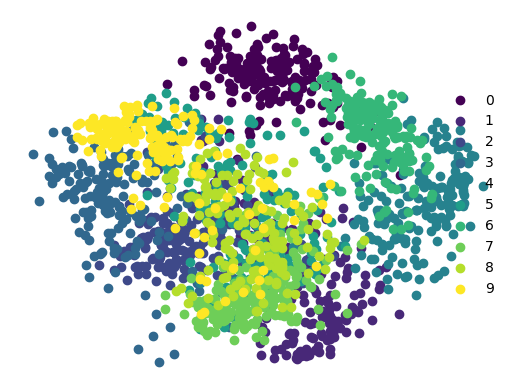

In [18]:
# Compare to PCA?
fig,ax=plt.subplots()
cs = cm.get_cmap('viridis', 10).colors
for i in range(10):
    ax.scatter(pcaDigits[target==i,0],pcaDigits[target==i,1],color=cs[i],label=i)
ax.legend(frameon=False,loc='right')
ax.set_axis_off()
plt.show()

### Vergleich mit PCA
<img style="float: left;" width=60% src="pca_embedding.png">

### Conclusion
| **Pros** | **Cons** |
|:----:|:----:|
|Findet häufig gute Visualisierung      | Keine Abbildung     |
| Ähnliche Sample clustern häufig zusammen      | Keine Rücktransformation      |
|  -    | Dimensionen bedeutungslos     |

In [19]:
# Generate Distance matrix
dists = np.zeros((a.shape[0],a.shape[0]))
for i in range(a.shape[0]):
    for j in range(a.shape[0]):
        dists[i,j]=np.linalg.norm(a[i,:]-a[j,:])

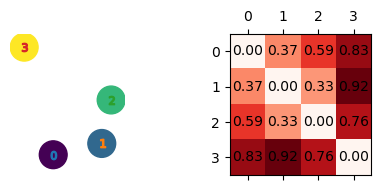

In [20]:
# Add this to Neighbor slide?
fig, ax = plt.subplots(1,2,figsize=(5,2),gridspec_kw={'width_ratios': [1, 1]})
ax[0].scatter(a[:,0],a[:,1],c=[1,2,3,4],s=400)
ax[0].set_xlim(-0.1,np.max(a[:,0]+0.1))
ax[0].set_ylim(-0.1,np.max(a[:,1]+0.1))
ax[0].set_aspect('equal', adjustable='box')
for i in range(a.shape[0]):
    ax[0].scatter(a[i,0],a[i,1], marker="$"+str(i)+"$")
ax[0].set_axis_off()
ax[1].matshow(dists,cmap=plt.cm.Reds)
for i in range(a.shape[0]):
    for j in range(a.shape[0]):
        c = dists[i,j]
        ax[1].text(i, j, '%.2f'%c, va='center', ha='center')
fig.tight_layout()

In [21]:
def plot1DEmbedding(iteration,gradientPoint):
    eta = 5
    fig,ax = plt.subplots()
    maxVal=np.max(Y[iteration,:,0])
    minVal=np.min(Y[iteration,:,0])
    points=(Y[iteration,:,0]-minVal)/(maxVal-minVal)
    ax.scatter(points,np.zeros(Y.shape[1]),c=[1,2,3,4],s=400)
    ax.set_ylim(-0.02,0.02)
    for i in range(Y.shape[1]):
        ax.scatter(points[i],0, marker="$"+str(i)+"$")
    ax.arrow(points[gradientPoint],0,eta * gradients[iteration,gradientPoint,0]/maxVal,0,length_includes_head=True,
          head_width=0.004, head_length=0.1)
    ax.set_xlim(-0.5,1.5)
    ax.set_axis_off()
    plt.show()

In [22]:
interact(plot1DEmbedding,iteration=widgets.IntSlider(min=0, max=30, step=1, value=0),gradientPoint=widgets.IntSlider(min=0, max=3, step=1, value=0));

interactive(children=(IntSlider(value=0, description='iteration', max=30), IntSlider(value=0, description='gra…